In [1]:
import numpy as np

import matplotlib.pyplot as plt

import WDM


# Wavelet transform (exact)

In [2]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=1.0, Nf=16, N=512)

x = np.random.normal(size=wdm.N) # white noise

w = wdm.forward_transform_exact(x)

x_recovered = wdm.inverse_transform_exact(w)

err = np.max(np.abs(x - x_recovered))

print(f"Check small error: {err}")

Check small error: 9.071175020025635e-07


# The truncated wavelet transform

In [34]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=0.5, 
                                                                Nf=4, 
                                                                N=32, 
                                                                q=4)
x = np.random.normal(size=wdm.N) # white noise

w = wdm.forward_transform_exact(x)

W = wdm.forward_transform_truncated(x)

assert np.allclose(W, w, rtol=1.0e-2, atol=1.0e-2), \
    "Truncated transform did not match exact transform"

In [32]:
64/(2)

32.0

In [3]:
q_vals = [1,2]#,4,8,10,12,14,16]

err_vals = np.zeros(len(q_vals))

for i, q in enumerate(q_vals): 
    wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=1.0, Nf=16, N=512, q=q)

    w = wdm.forward_transform_truncated(x)

    x_recovered = wdm.inverse_transform_truncated(w)

    err_vals[i] = np.max(np.abs(x - x_recovered))

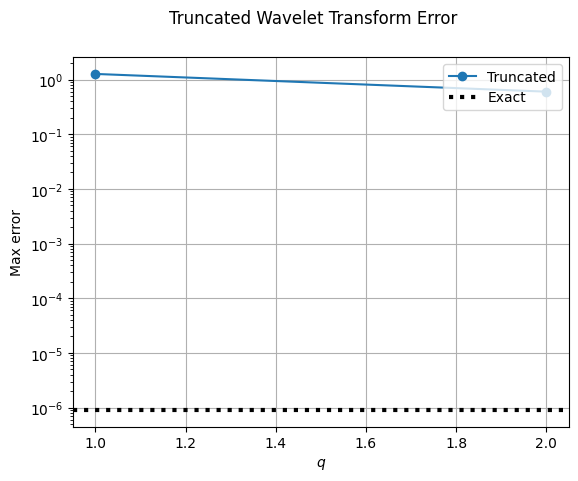

In [4]:
fig, ax = plt.subplots()
fig.suptitle("Truncated Wavelet Transform Error")

ax.plot(q_vals, err_vals, marker='o', label='Truncated')
ax.axhline(err, color='k', lw=3, linestyle=':', label='Exact')

ax.set_xlabel(r"$q$")
ax.set_ylabel(r"Max error")

ax.set_yscale('log')

ax.grid()
ax.legend(loc='upper right')

plt.show()

# The truncated wavelet transform using the window

In [5]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=1.0, Nf=16, N=512)

w = wdm.forward_transform_truncated_window(x)

W = wdm.forward_transform_truncated(x)

print(f"Check small difference: {np.max(np.abs(w-W))}")

Check small difference: 5.666366877932205e-07


# windowed FFT

In [6]:
w = wdm.forward_transform_truncated_windowed_fft(x)

W = wdm.forward_transform_truncated(x)

print(f"Check small difference: {np.max(np.abs(w[:,1:]-W[:,1:]))}")

Check small difference: 5.666366851286853e-07


# FFT

In [7]:
w = wdm.forward_transform_truncated_fft(x)

W = wdm.forward_transform_truncated(x)

print(f"Check small difference: {np.max(np.abs(w[:,1:]-W[:,1:]))}")

Check small difference: 10.959223203134451


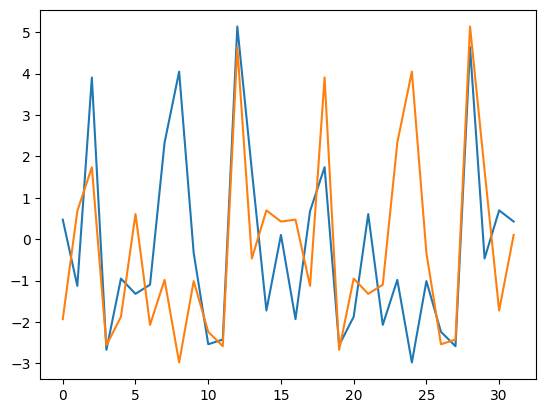

In [8]:
plt.plot(w[:,1])
plt.plot(W[:,1])
plt.show()

In [9]:
wdm = WDM.code.discrete_wavelet_transform.WDM.WDM_transform(dt=0.5, Nf=16, N=512)


import jax.numpy as jnp
basis = jnp.array([[wdm.gnm(n,m) for n in range(wdm.Nt)] for m in range(wdm.Nf)])

In [10]:
b = wdm.gnm_basis()  

In [11]:
b = b.reshape(b.shape[0], -1)

In [12]:
I = b @ b.T * 2. * jnp.pi * wdm.dt

In [13]:
jnp.allclose(I, jnp.eye(wdm.N), atol=1e-3, rtol=1e-3)

Array(True, dtype=bool)